# Outline:
* [Configuration](#config)
* [Functions](#functions)
* [Loading-data](#loading-data)
* [Data-manipulation](#manipulation)
* [Representation](#representation)

# Configuration <a class='anchor' id='config'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


url_csse_covid_19_daily_reports = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                   "csse_covid_19_data/csse_covid_19_daily_reports")
url_csse_covid_19_daily_reports_us = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                      "csse_covid_19_data/csse_covid_19_daily_reports_us")

url_time_series_covid19_confirmed_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
url_time_series_covid19_deaths_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
url_time_series_covid19_recovered_global = ("https://github.com/CSSEGISandData/COVID-19/raw/master/"
 "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

url_time_series_covid19_confirmed_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
url_time_series_covid19_deaths_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

yesterday = datetime.date.today() - datetime.timedelta(days=1)
url_apple_mobility_trends = ('https://covid19-static.cdn-apple.com/covid19-mobility-data/'
                             f'2009HotfixDev19/v3/en-us/applemobilitytrends-{yesterday}.csv')
url_google_mobility_report = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# Functions <a class='anchor' id='functions'></a>

In [2]:
def load_data(url, dtype=None):    
    import os
    from six.moves import urllib
    _, filename = url.rsplit('/', 1)
    filename = str(datetime.date.today()) + '_' + filename
    filepath = 'datasets/' + filename
    if not os.path.isdir('datasets'):
        os.makedirs('datasets')
    try:
        if not os.path.exists(filepath):
            urllib.request.urlretrieve(url, filepath)
    except:
        print('Could not retrieve ' + url)
        raise
    return pd.read_csv(filepath, dtype=dtype)

def format_columns(df):
    column_mapping = {'sub_region_1': 'province_state', 'sub_region_2': 'county', 'admin2': 'county',
                 'country/region':'country_region', 'province/state': 'province_state', 'long_': 'long'}    
    dates = {}
    names = {}
    for col in df.columns:
        try:
            dates[col] = pd.to_datetime(col).date()
        except:
            names[col] = str.lower(col)
    df = df.rename(columns=names).rename(columns=dates)    
    cols_order = list(names.values()) + sorted(dates.values(), reverse=True)
    df = df[cols_order]
    df = df.rename(columns=column_mapping)
    if 'county' not in df.columns:
        df['county'] = np.nan    
    df = df.astype({'country_region': str, 'province_state': str, 'county': str})
    return df

def format_cells(df):
    df = df.copy()
    name_mapping = {'The Bahamas':'Bahamas', "Côte d'Ivoire":"Cote d'Ivoire", 'Myanmar (Burma)': 'Burma', 
                 'Korea, South': 'South Korea', 'Taiwan*':'Taiwan', 'US': 'United States'} 
    regex_mapping = {r'\s(p|P)rovince': '', r'\s(c|C)ounty': ''}
    df = df.replace(to_replace=name_mapping).replace(regex=regex_mapping)
    if 'population' in df.columns:
        df.loc[df['population'] <= 0, 'population'] = np.nan
    return df

def sparse_columns(df, sparsity_level=0.5):
    return df.columns[df.isna().sum() > df.shape[0] * sparsity_level].values


In [3]:
def get_time_series_data(url):
    df = format_cells(format_columns(load_data(url)))
    date_columns = [c for c in df.columns if isinstance(c, datetime.date)]
    # melt: Unpivots a DataFrame from wide format to long format
    df = df.melt(value_vars=date_columns,
                 id_vars=['country_region', 'province_state', 'county'], 
                 var_name='date', 
                 value_name='values')
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()

In [4]:
def get_google_mobility_data(url):
    df_mobility = load_data(url)
    df_mobility = format_cells(format_columns(df_mobility))
    df_mobility.loc[df_mobility['country_region'] == 'Aruba', 
                    ['country_region', 'province_state']] = ('Netherlands', 'Aruba')
    df_mobility.loc[df_mobility['country_region'] == 'Réunion', 
                    ['country_region', 'province_state']] = ('France', 'Réunion')
    df_mobility.loc[df_mobility['country_region'] == 'Hong Kong'
                    , ['country_region', 'province_state']] = ('China', 'Hong Kong')
    df_mobility['mobility'] = None
    cols = df_mobility.columns[-7:-1]
    df_mobility['mobility'] = df_mobility[cols].mean(axis=1).round(1)
    df_mobility['date'] = pd.to_datetime(df_mobility['date'])
    df_mobility = df_mobility.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()
    return df_mobility['mobility']

In [5]:
def load_main_dataframe(date=None):
    if date is None:
        date = datetime.datetime.today().date()
    return (pd.read_csv(f'datasets/{date}_df.csv', keep_default_na=False,
                        index_col=['country_region', 'province_state', 'county', 'date'], 
                        dtype={'country_region':str, 'province_state':str, 'county':str},
                        parse_dates=True)
            .sort_index(level=[0,1,2,3]))

def load_xy_dataframe(date=None):
    if date is None:
        date = datetime.datetime.today().date()
    return pd.read_csv(f'datasets/{date}_df-yX.csv', float_precision='high')

# Loading data <a class='anchor' id='loading-data'></a>

**Fetch time series**

In [6]:
%%time
df_global_confirmed = get_time_series_data(url_time_series_covid19_confirmed_global).rename(columns={'values':'confirmed'})
df_global_deaths = get_time_series_data(url_time_series_covid19_deaths_global).rename(columns={'values':'deaths'})
df_us_confirmed = get_time_series_data(url_time_series_covid19_confirmed_US).rename(columns={'values':'confirmed'})
df_us_deaths= get_time_series_data(url_time_series_covid19_deaths_US).rename(columns={'values':'deaths'})

df_confirmed = df_global_confirmed.append(df_us_confirmed)
df_deaths = df_global_deaths.append(df_us_deaths)
df = pd.merge(left=df_confirmed, right=df_deaths, left_index=True, right_index=True, how='inner')

Wall time: 9.28 s


In [7]:
idx = pd.IndexSlice
df.loc[idx['United States', :, :, '2020-06-03']]

confirmed  deaths
province_state county                       
nan            nan           1851520  107175
Alabama        Autauga           239       5
               Baldwin           292       9
               Barbour           177       1
               Bibb               76       1
...                              ...     ...
Wyoming        Teton             100       0
               Uinta              13       0
               Unassigned          0      16
               Washakie           37       0
               Weston              1       0

[3262 rows x 2 columns]

**Fill mobility trends in different regions of the world**

In [8]:
%%time
df_mobility = get_google_mobility_data(url_google_mobility_report)

C:\Users\Abtin\Miniconda2\envs\py36\lib\site-packages\IPython\core\magics\execution.py:1310: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 14.3 s


Merge mobility with our main dataframe

In [9]:
%%time
df = pd.merge(left=df, right=df_mobility, left_index=True, right_index=True, how='inner')

Wall time: 6.94 s


In [10]:
df = df.sort_index()

In [11]:
df.loc[idx['France', :, :, '2020-05-25': '2020-05-27']]

confirmed  deaths  mobility
country_region province_state county date                                   
France         nan            nan    2020-05-25     180166   28407     -16.3
                                     2020-05-26     179887   28480     -14.2
                                     2020-05-27     180044   28546     -14.7

**Calculating *new_confirmed* and *new_deaths***

In [12]:
%%time
df[['new_confirmed', 'new_deaths']] = df[['confirmed', 'deaths']].diff()

Wall time: 18.9 ms


In [13]:
%%time
headindex, tailindex = [], []
for name, group in df.groupby(axis='index', level=[0,1,2]):    
    headindex.append(group.index.values[0])
    tailindex.append(group.index.values[-1])
headindex = pd.MultiIndex.from_tuples(headindex)
tailindex = pd.MultiIndex.from_tuples(tailindex)

Wall time: 3.66 s


In [14]:
%%time
df.loc[headindex, 'new_confirmed'] = df.loc[headindex, 'confirmed']
df.loc[headindex, 'new_deaths'] = df.loc[headindex, 'deaths']

Wall time: 528 ms


**Saving our dataset:**

In [15]:
df['new_deaths'] = df['new_deaths'].astype('Int32')
df['new_confirmed'] = df['new_confirmed'].astype('Int32')
df = df[['mobility', 'confirmed', 'new_confirmed', 'deaths', 'new_deaths']]
df.to_csv(f'datasets/{datetime.datetime.today().date()}_df.csv', index=True)

# Data Manipulation <a class='anchor' id='manipulation'></a>

Use final week as of indicator

In [16]:
df = load_main_dataframe()

In [17]:
week = pd.Timedelta('7 days')
day = pd.Timedelta('1 day')
closing_date = df.index.levels[3].max()
indicator_period = (closing_date - week, closing_date)
predictor_period = (closing_date - 5 * week - day, closing_date - week - day)
print('Predictor period:', predictor_period)
print('Indicator period:', indicator_period)
df_indicator = df.loc[idx[:,:,:, indicator_period[0]: indicator_period[1]], :].copy()
df_predictor = df.loc[idx[:,:,:, predictor_period[0]: predictor_period[1]], :].copy()

Predictor period: (Timestamp('2020-04-23 00:00:00'), Timestamp('2020-05-21 00:00:00'))
Indicator period: (Timestamp('2020-05-22 00:00:00'), Timestamp('2020-05-29 00:00:00'))


In [18]:
%%time
not_included = []
for name , group in df_indicator.groupby(axis='index', level=[0,1,2]):
    try:
        df_predictor.loc[name, '_n_c_baseline'] = df_predictor.loc[name, 'new_confirmed'].median()
        df_predictor.loc[name, '_n_d_baseline'] = df_predictor.loc[name, 'new_deaths'].median()
        df_indicator.loc[name, '_n_c_baseline'] = df_indicator.loc[name, 'new_confirmed'].median()
        df_indicator.loc[name, '_n_d_baseline'] = df_indicator.loc[name, 'new_deaths'].median()
        count_names += 1
    except:
        not_included.append(name)
print('Number of locations missing in df_predictor:', len(not_included))

Number of locations missing in df_predictor: 2873
Wall time: 37.7 s


In [19]:
df_predictor['_new_death_change_rate'] = (
    (df_predictor['new_deaths'] - df_predictor['_n_d_baseline']) / (df_predictor['_n_d_baseline'] + 1.01))
df_indicator['_new_death_change_rate'] = (
    (df_indicator['new_deaths'] - df_indicator['_n_d_baseline']) / (df_indicator['_n_d_baseline'] + 1.01))
df_predictor['_new_confirmed_change_rate'] = (
    (df_predictor['new_confirmed'] - df_predictor['_n_c_baseline']) / (df_predictor['_n_c_baseline'] + 1.01))
df_indicator['_new_confirmed_change_rate'] = (
    (df_indicator['new_confirmed'] - df_indicator['_n_c_baseline']) / (df_indicator['_n_c_baseline'] + 1.01))
df_predictor[['_new_confirmed_change_rate', '_new_death_change_rate']] = (100 *
    df_predictor[['_new_confirmed_change_rate', '_new_death_change_rate']]).round(3)
df_indicator[['_new_confirmed_change_rate', '_new_death_change_rate']] = (100 *
    df_indicator[['_new_confirmed_change_rate', '_new_death_change_rate']].round(3))

In [20]:
%%time
df_y = (df_indicator[['new_confirmed', 'new_deaths', '_new_death_change_rate', '_new_confirmed_change_rate']]
        .groupby(axis='index', level=[0,1,2])
        .agg(np.average)
        .round(3))
df_y = df_y.dropna(subset=['_new_death_change_rate', '_new_confirmed_change_rate'])
df_y.columns = [f'Y_weekavg_{x}' for x in df_y.columns.ravel()]

Wall time: 2.99 s


In [21]:
df_y.head(3)

,,,Y_weekavg_new_confirmed,Y_weekavg_new_deaths,Y_weekavg__new_death_change_rate,Y_weekavg__new_confirmed_change_rate
country_region,province_state,county,,,,
Afghanistan,nan,nan,622.875,6.625,-10.288,2.625
Angola,nan,nan,2.875,0.125,12.375,54.787
Antigua and Barbuda,nan,nan,0.000,0.000,0.000,0.000


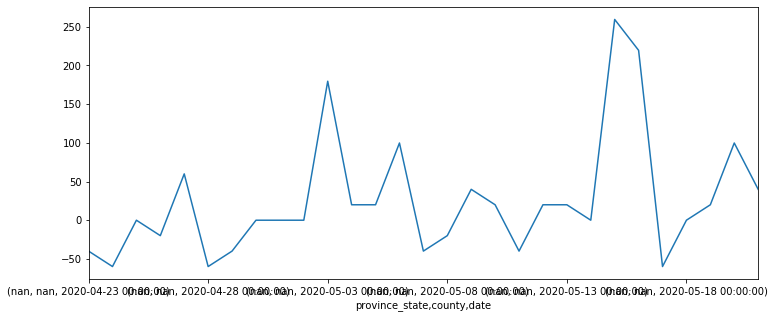

In [22]:
df_predictor.loc[idx['Afghanistan'], '_new_death_change_rate'].plot(figsize=(12, 5))

In [23]:
%%time
yindex = set(df_y.index.ravel())
xindex = []
for name, group in df_predictor.groupby(axis='index', level=[0,1,2]):
    if name in yindex:
        xindex += [*group.index.values]

Wall time: 2.71 s


In [24]:
%%time
xindex = pd.MultiIndex.from_tuples(xindex)
df_predictor = df_predictor.loc[xindex]

Wall time: 1.17 s


In [25]:
df_X = (df_predictor
        .reset_index()
        .pivot_table(values=['mobility', '_new_death_change_rate', '_new_confirmed_change_rate'], 
                     index=['country_region', 'province_state', 'county'], 
                     columns=['date']))
df_X.columns = [f'X_{x[0]}_{x[1].date()}' for x in df_X.columns]

In [26]:
df_X.head(3)

,,,X__new_confirmed_change_rate_2020-04-23,X__new_confirmed_change_rate_2020-04-24,X__new_confirmed_change_rate_2020-04-25,X__new_confirmed_change_rate_2020-04-26,X__new_confirmed_change_rate_2020-04-27,X__new_confirmed_change_rate_2020-04-28,X__new_confirmed_change_rate_2020-04-29,X__new_confirmed_change_rate_2020-04-30,X__new_confirmed_change_rate_2020-05-01,X__new_confirmed_change_rate_2020-05-02,...,X_mobility_2020-05-12,X_mobility_2020-05-13,X_mobility_2020-05-14,X_mobility_2020-05-15,X_mobility_2020-05-16,X_mobility_2020-05-17,X_mobility_2020-05-18,X_mobility_2020-05-19,X_mobility_2020-05-20,X_mobility_2020-05-21
country_region,province_state,county,,,,,,,,,,,,,,,,,,,,,
Afghanistan,nan,nan,-55.93,-69.065,-52.116,-70.76,-26.694,-46.608,-52.54,-1.271,-30.083,-42.795,...,-21.8,-21.7,-20.3,-9.3,-14.3,-20.0,-15.8,-16.8,-17.2,-15.7
Angola,nan,nan,0.00,0.000,0.000,99.01,99.010,0.000,0.00,0.000,297.030,495.050,...,-21.2,-23.0,-20.3,-22.3,-15.5,-26.3,-22.2,-22.0,-23.7,-20.5
Antigua and Barbuda,nan,nan,0.00,0.000,0.000,0.00,0.000,0.000,0.00,0.000,99.010,0.000,...,-30.2,-30.3,-27.5,-24.0,-34.0,-38.8,-25.0,-26.3,-25.8,-25.3


In [27]:
df_X.index.equals(df_y.index)

True

In [28]:
df_yX = (pd.merge(left=df_y, right=df_X, left_index=True, right_index=True, how='inner')
         .reset_index())
df_yX[['country_region', 'province_state', 'county']] = \
                df_yX[['country_region', 'province_state', 'county']].replace('nan', '')
df_yX['country_region'] = df_yX['country_region'] + df_yX['province_state'] + df_yX['county']
df_yX = df_yX.drop(axis=1, labels=['province_state', 'county']).rename(columns={'country_region':'location'})
df_yX.head(3)

,location,Y_weekavg_new_confirmed,Y_weekavg_new_deaths,Y_weekavg__new_death_change_rate,Y_weekavg__new_confirmed_change_rate,X__new_confirmed_change_rate_2020-04-23,X__new_confirmed_change_rate_2020-04-24,X__new_confirmed_change_rate_2020-04-25,X__new_confirmed_change_rate_2020-04-26,X__new_confirmed_change_rate_2020-04-27,...,X_mobility_2020-05-12,X_mobility_2020-05-13,X_mobility_2020-05-14,X_mobility_2020-05-15,X_mobility_2020-05-16,X_mobility_2020-05-17,X_mobility_2020-05-18,X_mobility_2020-05-19,X_mobility_2020-05-20,X_mobility_2020-05-21
0,Afghanistan,622.875,6.625,-10.288,2.625,-55.93,-69.065,-52.116,-70.76,-26.694,...,-21.8,-21.7,-20.3,-9.3,-14.3,-20.0,-15.8,-16.8,-17.2,-15.7
1,Angola,2.875,0.125,12.375,54.787,0.00,0.000,0.000,99.01,99.010,...,-21.2,-23.0,-20.3,-22.3,-15.5,-26.3,-22.2,-22.0,-23.7,-20.5
2,Antigua and Barbuda,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.00,0.000,...,-30.2,-30.3,-27.5,-24.0,-34.0,-38.8,-25.0,-26.3,-25.8,-25.3


In [38]:
print('Dataset shape:', df_yX.shape)
df_yX.to_csv(f'datasets/{datetime.datetime.today().date()}_df-yX.csv', index=False)

Dataset shape: (2863, 92)


In [30]:
dd2 = load_xy_dataframe()

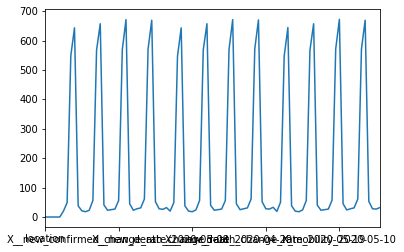

In [31]:
(dd2 != df_yX).sum().plot()

# Representation <a class='anchor' id='representation'></a>

In [32]:
%matplotlib inline

In [33]:
df = load_main_dataframe()

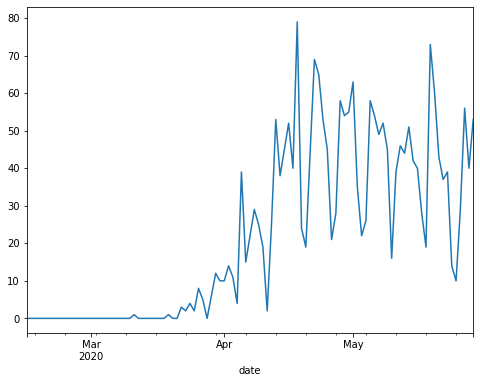

In [34]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'new_deaths'].plot(figsize=(8, 6))

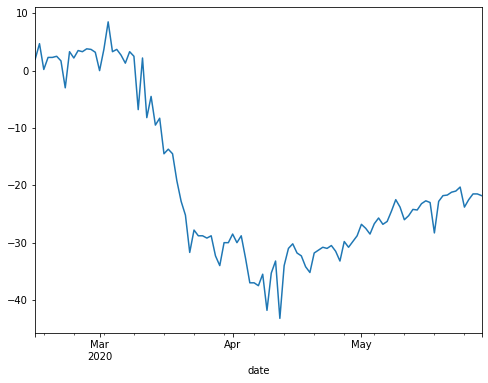

In [35]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'mobility'].plot(figsize=(8, 6))